In [52]:
import pandas as pd
import numpy as np

df = pd.read_csv('Datasets/csv_files/uk_housing_2020.csv', encoding='latin1', thousands=',')
df.head()

,AREACD,AREANM,earnings,Estimated Population mid-2019,Year ending Mar 2020,2019 people per sq. km
0,E06000001,Hartlepool,557.2,93663,128500,999
1,E06000002,Middlesbrough,556.8,140980,137000,2616
2,E06000003,Redcar and Cleveland,506.2,137150,132950,560
3,E06000004,Stockton-on-Tees,537.3,197348,150000,963
4,E06000005,Darlington,519.3,106803,144000,541


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   AREACD                         336 non-null    object 
 1   AREANM                         336 non-null    object 
 2   earnings                       335 non-null    float64
 3   Estimated Population mid-2019  336 non-null    int64  
 4   Year ending Mar 2020           336 non-null    int64  
 5   2019 people per sq. km         336 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 15.9+ KB


In [54]:
df.rename(columns={'AREACD': 'area_code', 'AREANM': 'area_name', 'earnings': 'earnings_per_week', 'Year ending Mar 2020': 'median_house_price_paid_mar_2020', '2019 people per sq. km': 'density_per_sq.km_2019', 'Estimated Population mid-2019': 'population_2019' }, inplace=True)

In [55]:
df.describe()

,earnings_per_week,population_2019,median_house_price_paid_mar_2020,density_per_sq.km_2019
count,335.000000,3.360000e+02,3.360000e+02,336.000000
mean,564.967463,1.769043e+05,2.719484e+05,1721.967262
std,83.505875,1.199554e+05,1.388520e+05,2598.663864
min,427.000000,2.224000e+03,9.000000e+04,25.000000
25%,516.500000,1.014192e+05,1.750000e+05,215.750000
50%,549.700000,1.383630e+05,2.400000e+05,603.500000
75%,590.300000,2.153825e+05,3.215000e+05,2314.500000
max,1103.100000,1.141816e+06,1.300000e+06,16427.000000


In [56]:
df.isnull().sum()

area_code                           0
area_name                           0
earnings_per_week                   1
population_2019                     0
median_house_price_paid_mar_2020    0
density_per_sq.km_2019              0
dtype: int64

In [57]:
df = df.dropna()
df.isnull().sum()

area_code                           0
area_name                           0
earnings_per_week                   0
population_2019                     0
median_house_price_paid_mar_2020    0
density_per_sq.km_2019              0
dtype: int64

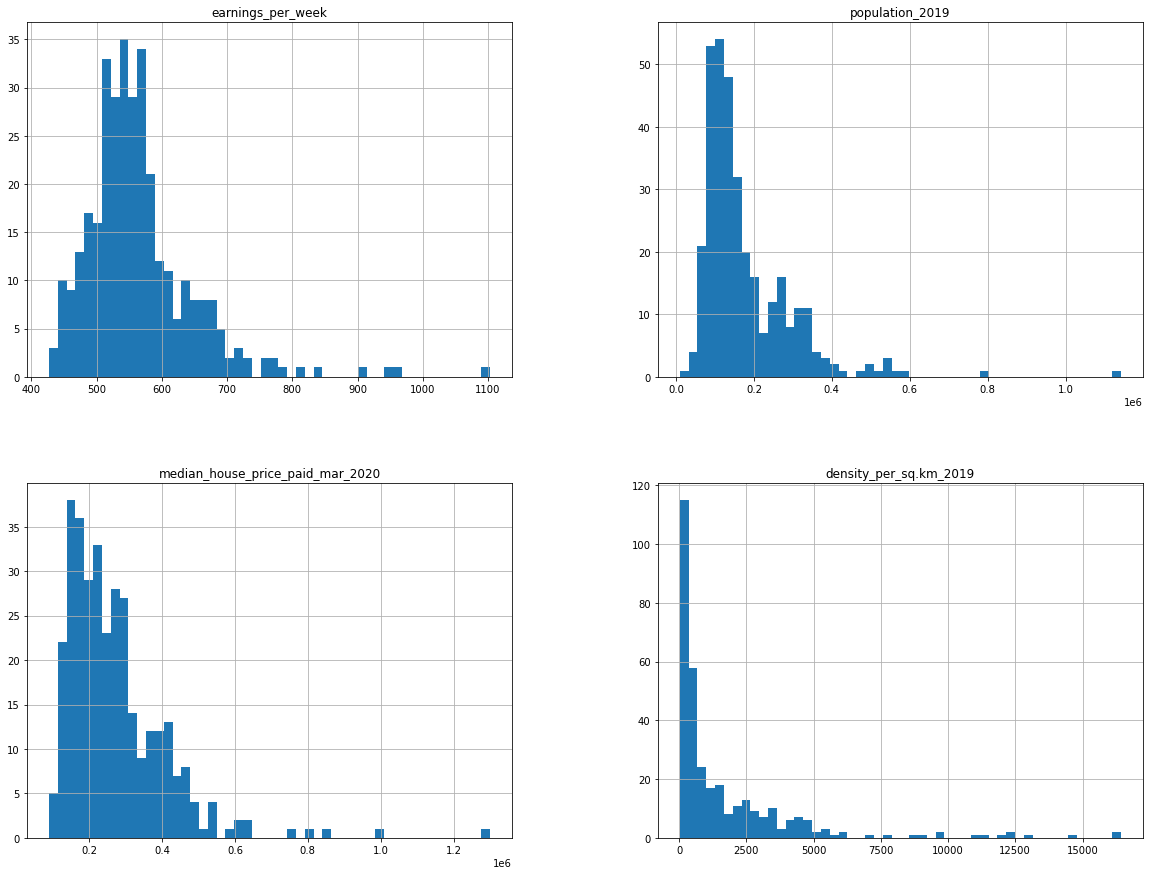

In [58]:
%matplotlib inline  
## The 'matplotlib inline' only works in Jupyter Notebook  ##
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,15))
plt.show()

In [59]:
df['earnings_per_week'].min()

427.0

### Overall, the histograms are 'tail-heavy' ie they are left-wards leaning (positively skewed). This may make it harder for some Machine Learning algorithms to detect patterns. We might be able to transform these attributes to have more of a Gaussian bell-shaped distribution.

# Creating a Test Set

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X = df[['earnings_per_week','density_per_sq.km_2019']]
Y = df[['median_house_price_paid_mar_2020']]

x_train, x_test, y_train, y_test = train_test_split(X,Y, train_size=0.8, test_size=0.2, random_state=10)

In [62]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

268
67
268
67


In [63]:
x_train

,earnings_per_week,density_per_sq.km_2019
81,477.5,199
99,520.7,436
149,536.7,666
60,558.2,196
37,634.2,771
...,...,...
124,515.9,224
321,492.9,78
15,536.2,4830
126,590.3,1548


### However, we may have an issue here. SImply because our datasets is not large enough to be considered as a large dataset, we run the risk of introducing a significant sampling bias. We want the significant or important attributes to be representative of the overall population. If you run a certain survey at a purely random sampling to a population of 51% female, 49% male, you have about 12% chance of sampling a skewed test set that either makes less than 49% female, or 54% female. Overall, the results would be significantly biased.

### To mitigate this problem, we will use another type of train and test set.

<AxesSubplot:>

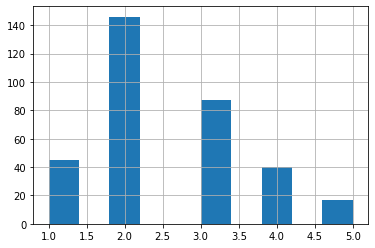

In [64]:
df['income_cat'] = pd.cut(df['earnings_per_week'], bins=[420., 490., 560., 630., 700., np.inf], labels=[1,2,3,4,5])
df['income_cat'].hist()

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit

In [66]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['income_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [67]:
rand_train_x, rand_test_x, rand_train_y, rand_test_y = train_test_split(df['income_cat'],df['median_house_price_paid_mar_2020'], train_size=0.8, test_size=0.2, random_state=10)

In [68]:
Stratified = strat_test_set['income_cat'].value_counts() / len(strat_test_set)

In [69]:
Overall = df['income_cat'].value_counts() / len(df)

In [70]:
Random = rand_test_x.value_counts() / len(rand_test_x)

In [71]:
data = {'Overall': Overall,
        'Stratified': Stratified,
        'Random':Random}

df_sampling_bias_comp = pd.DataFrame(data)
df_sampling_bias_comp

,Overall,Stratified,Random
2,0.435821,0.432836,0.477612
3,0.259701,0.268657,0.343284
1,0.134328,0.134328,0.074627
4,0.119403,0.119403,0.059701
5,0.050746,0.044776,0.044776


In [72]:
df_sampling_bias_comp['Rand. %error'] = (df_sampling_bias_comp['Random'] - df_sampling_bias_comp['Overall'])*100 / df_sampling_bias_comp['Overall']
df_sampling_bias_comp['Strat. %error'] = (df_sampling_bias_comp['Stratified'] - df_sampling_bias_comp['Overall'])*100 / df_sampling_bias_comp['Overall']

In [73]:
df_sampling_bias_comp

,Overall,Stratified,Random,Rand. %error,Strat. %error
2,0.435821,0.432836,0.477612,9.589041,-0.684932
3,0.259701,0.268657,0.343284,32.183908,3.448276
1,0.134328,0.134328,0.074627,-44.444444,0.000000
4,0.119403,0.119403,0.059701,-50.000000,0.000000
5,0.050746,0.044776,0.044776,-11.764706,-11.764706


### Lets now drop these income_cat attribute

In [74]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [75]:
df.head()

,area_code,area_name,earnings_per_week,population_2019,median_house_price_paid_mar_2020,density_per_sq.km_2019,income_cat
0,E06000001,Hartlepool,557.2,93663,128500,999,2
1,E06000002,Middlesbrough,556.8,140980,137000,2616,2
2,E06000003,Redcar and Cleveland,506.2,137150,132950,560,2
3,E06000004,Stockton-on-Tees,537.3,197348,150000,963,2
4,E06000005,Darlington,519.3,106803,144000,541,2


## Looking for Correlations

### - The correlation below is the 'Product Moment Correlation Coefficient' or simply 'Pearson's r'

In [76]:
corr_matrix = df.corr()

In [77]:
corr_matrix

,earnings_per_week,population_2019,median_house_price_paid_mar_2020,density_per_sq.km_2019
earnings_per_week,1.000000,0.118232,0.567545,0.484857
population_2019,0.118232,1.000000,0.024152,0.344340
median_house_price_paid_mar_2020,0.567545,0.024152,1.000000,0.559873
density_per_sq.km_2019,0.484857,0.344340,0.559873,1.000000


In [78]:
corr_matrix["median_house_price_paid_mar_2020"].sort_values(ascending=False)

median_house_price_paid_mar_2020    1.000000
earnings_per_week                   0.567545
density_per_sq.km_2019              0.559873
population_2019                     0.024152
Name: median_house_price_paid_mar_2020, dtype: float64

### - Using pandas scatter matrix

array([[<AxesSubplot:xlabel='median_house_price_paid_mar_2020', ylabel='median_house_price_paid_mar_2020'>,
        <AxesSubplot:xlabel='earnings_per_week', ylabel='median_house_price_paid_mar_2020'>,
        <AxesSubplot:xlabel='density_per_sq.km_2019', ylabel='median_house_price_paid_mar_2020'>],
       [<AxesSubplot:xlabel='median_house_price_paid_mar_2020', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='earnings_per_week', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='density_per_sq.km_2019', ylabel='earnings_per_week'>],
       [<AxesSubplot:xlabel='median_house_price_paid_mar_2020', ylabel='density_per_sq.km_2019'>,
        <AxesSubplot:xlabel='earnings_per_week', ylabel='density_per_sq.km_2019'>,
        <AxesSubplot:xlabel='density_per_sq.km_2019', ylabel='density_per_sq.km_2019'>]],
      dtype=object)

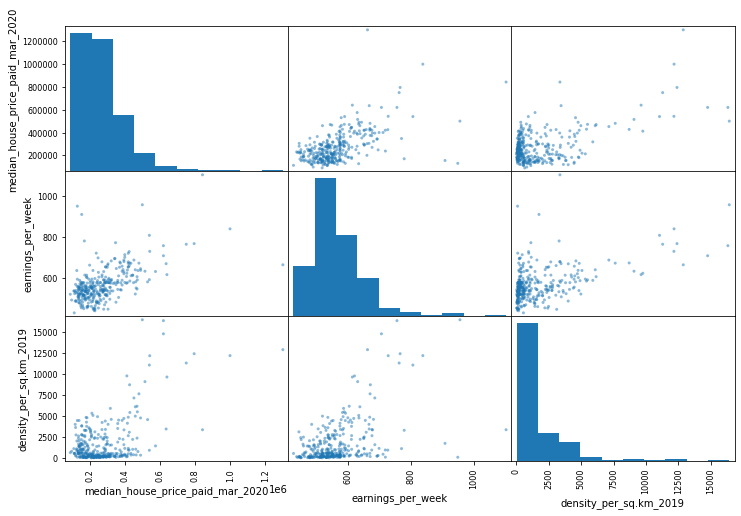

In [79]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_price_paid_mar_2020", 'earnings_per_week', 'density_per_sq.km_2019']

scatter_matrix(df[attributes], figsize=(12,8))

<AxesSubplot:xlabel='earnings_per_week', ylabel='median_house_price_paid_mar_2020'>

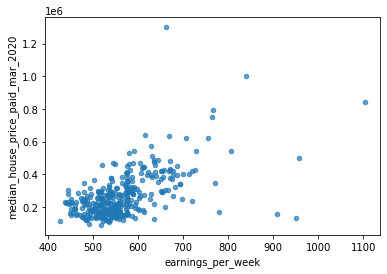

In [80]:
df.plot(kind='scatter', x='earnings_per_week', y='median_house_price_paid_mar_2020', alpha=0.7)

## Experimenting with Attribute Combinations & Preparing Data for Machine Learning Algorithm (Data Cleaning)

### - As we have noticed some attributes have a tail-heavy distribution, so we can transform them by computing their logarithm.

In [83]:
housing_labels = strat_train_set['median_house_price_paid_mar_2020'].copy()
df_attributes = strat_train_set.drop(["median_house_price_paid_mar_2020", "area_code", "area_name"], axis=1)
df_attributes

,earnings_per_week,population_2019,density_per_sq.km_2019
303,671.4,305842,8702
269,611.5,371521,3766
66,517.6,53253,25
319,565.7,135957,270
332,574.9,94590,111
...,...,...,...
86,534.8,103268,354
120,611.9,104919,1037
147,455.8,112091,397
320,451.5,72695,41


### - Missing values or null values can be drop or replaced, which Scikit-Learn provides a handy class to take care of the missing values: SimpleImputer 

In [84]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(df_attributes)

SimpleImputer(strategy='median')

In [85]:
imputer.statistics_

array([   549.9, 137215. ,    617. ])

In [86]:
df_attributes.median().values

array([   549.9, 137215. ,    617. ])

In [89]:
X = imputer.transform(df_attributes)

### - If our data have categorical attributes and is somewhat a targeted attribute as well, we can use OneHotEncoder which is demonstrated in the other machine learning notes. However, here we don't have any of them so we don't have to do any OneHotEncoder. Also Do not forget about the Multicollinearity problem which can occur when implementing the OneHotEncoder.

## Custom Transformers

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

earning_index, population_index, density_index = 2, 3, 5

class LogarithmiseAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_logarithms_density=True):
        self.add_logarithms_density = add_logarithms_density
        
    def fit(self, X, y=None):
        return self # no need to do anything here
    
    def transform(self, X):
        log_earnings = np.log10(X[:,earning_index])
        log_population = np.log10(X[:,earning_index])
        if self.add_logarithms_density:
            log_density = np.log10(X[:,density_index])
            return np.c_[X, log_earnings, log_population, log_density]
        else:
            return np.c_[X, log_earnings, log_population]
        
attr_adder = LogarithmiseAttributes(add_logarithms_density=False)
df_with_logs = attr_adder.transform(df.drop([ "area_code", "area_name", 'income_cat'], axis=1).values)

df_with_logs = pd.DataFrame(df_with_logs, columns = ["earnings_per_week","population_2019","median_house_price_paid_mar_2020","density_per_sq.km_2019",'log_earnings','log_population'])

df_with_logs
        

,earnings_per_week,population_2019,median_house_price_paid_mar_2020,density_per_sq.km_2019,log_earnings,log_population
0,557.2,93663.0,128500.0,999.0,5.108903,5.108903
1,556.8,140980.0,137000.0,2616.0,5.136721,5.136721
2,506.2,137150.0,132950.0,560.0,5.123688,5.123688
3,537.3,197348.0,150000.0,963.0,5.176091,5.176091
4,519.3,106803.0,144000.0,541.0,5.158362,5.158362
...,...,...,...,...,...,...
330,572.7,93961.0,157500.0,748.0,5.197281,5.197281
331,574.9,94590.0,262000.0,111.0,5.418301,5.418301
332,550.1,154676.0,179950.0,812.0,5.255152,5.255152
333,540.2,132435.0,180000.0,26.0,5.255273,5.255273


array([[<AxesSubplot:xlabel='earnings_per_week', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='population_2019', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='median_house_price_paid_mar_2020', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='density_per_sq.km_2019', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='log_earnings', ylabel='earnings_per_week'>,
        <AxesSubplot:xlabel='log_population', ylabel='earnings_per_week'>],
       [<AxesSubplot:xlabel='earnings_per_week', ylabel='population_2019'>,
        <AxesSubplot:xlabel='population_2019', ylabel='population_2019'>,
        <AxesSubplot:xlabel='median_house_price_paid_mar_2020', ylabel='population_2019'>,
        <AxesSubplot:xlabel='density_per_sq.km_2019', ylabel='population_2019'>,
        <AxesSubplot:xlabel='log_earnings', ylabel='population_2019'>,
        <AxesSubplot:xlabel='log_population', ylabel='population_2019'>],
       [<AxesSubplot:xlabel='earnings_per_week', ylabe

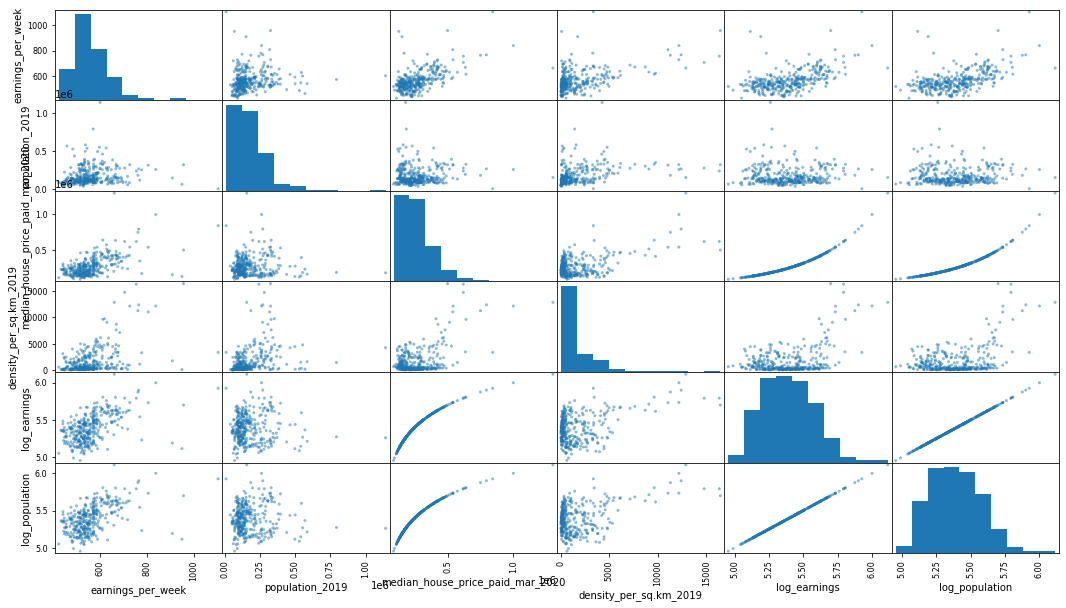